In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datasets import Dataset

from jigsaw.settings import DATA_DIR, MODEL_DIR


eval_path = DATA_DIR / "ds_spam_eval.ds"

eval_dataset = Dataset.load_from_disk(str(eval_path))

In [3]:
# BASE_MODEL_PATH = "/home/felix/.cache/huggingface/hub/models--Qwen--Qwen3-0.6B/snapshots/c1899de289a04d12100db370d81485cdf75e47ca"  # Model to fine-tune
BASE_MODEL_PATH = "unsloth/Qwen3-1.7B"  # Model to fine-tune
LORA_PATH = MODEL_DIR / "unsloth/Qwen3-0.6B-lora-finetuned-on-spam-yes-no"  # Where to save LoRA weights

In [4]:
import vllm
from vllm.lora.request import LoRARequest

llm = vllm.LLM(
    BASE_MODEL_PATH,
    quantization=None,  # "gptq",
    tensor_parallel_size=1,
    gpu_memory_utilization=0.7,
    trust_remote_code=True,
    dtype="half",
    enforce_eager=True,
    max_model_len=2836,
    disable_log_stats=True,
    enable_prefix_caching=True,
    enable_lora=True,
    max_lora_rank=64,
)

tokenizer = llm.get_tokenizer()
# mclp = MultipleChoiceLogitsProcessor(tokenizer, choices=["yes", "no"])

texts = eval_dataset["prompt"]

INFO 10-22 13:36:04 [__init__.py:235] Automatically detected platform cuda.


`torch_dtype` is deprecated! Use `dtype` instead!


WARNING 10-22 13:36:10 [config.py:3443] Casting torch.bfloat16 to torch.float16.
INFO 10-22 13:36:10 [config.py:1604] Using max model len 2836
INFO 10-22 13:36:12 [config.py:2434] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 10-22 13:36:13 [core.py:572] Waiting for init message from front-end.
INFO 10-22 13:36:13 [core.py:71] Initializing a V1 LLM engine (v0.10.0) with config: model='unsloth/Qwen3-1.7B', speculative_config=None, tokenizer='unsloth/Qwen3-1.7B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=True, dtype=torch.float16, max_seq_len=2836, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=True, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_prop

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 10-22 13:36:16 [default_loader.py:262] Loading weights took 0.78 seconds
INFO 10-22 13:36:16 [punica_selector.py:19] Using PunicaWrapperGPU.
INFO 10-22 13:36:17 [gpu_model_runner.py:1892] Model loading took 3.3454 GiB and 1.577496 seconds
INFO 10-22 13:36:20 [gpu_worker.py:255] Available KV cache memory: 0.56 GiB
INFO 10-22 13:36:20 [kv_cache_utils.py:833] GPU KV cache size: 5,280 tokens
INFO 10-22 13:36:20 [kv_cache_utils.py:837] Maximum concurrency for 2,836 tokens per request: 1.85x
INFO 10-22 13:36:20 [core.py:193] init engine (profile, create kv cache, warmup model) took 3.41 seconds


In [5]:
texts[:2]

[[{'content': "You are an unbiased moderator that classifies comments as violating a rule or not. You are moderating for the subreddit <subreddit> r/soccerstreams </subreddit>. The rule is <rule> No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed. </rule>. Does the given comment violate the rule? Respond with 'yes' or 'no'.Comment: <comment>[I wanna kiss you all over! Stunning!](http://www.oilflush.life/2017/01/26/6/)</comment>",
   'role': 'user'}],
 [{'content': "You are an unbiased moderator that classifies comments as violating a rule or not. You are moderating for the subreddit <subreddit> r/sex </subreddit>. The rule is <rule> No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed. </rule>. Does the given comment violate the rule? Respond with 'yes' or 'no'.Comment: <comment>Good News ::Download WhatsApp 2.16.230 APK for Android – Latest Version</comment>",
   'role': 'user'}]]

In [6]:
tokenizer = llm.get_tokenizer()

outputs = llm.generate(
    [tokenizer.apply_chat_template(text, tokenize=False, add_generation_prompt=True, enable_thinking=False) for text in texts],
    vllm.SamplingParams(
        skip_special_tokens=True,
        max_tokens=10,
        logprobs=2,
    ),
    use_tqdm=True,
    lora_request=LoRARequest("default", 1, str(LORA_PATH)),
)

log_probs = [
    {lp.decoded_token: lp.logprob for lp in out.outputs[0].logprobs[0].values()}
    for out in outputs
]

Adding requests:   0%|          | 0/173 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/173 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

In [7]:
for sample, out in zip(eval_dataset, outputs[:10]):
    print(sample["prompt"])
    print(sample["completion"][0]["content"])
    print(out.outputs[0].text)
    print()

[{'content': "You are an unbiased moderator that classifies comments as violating a rule or not. You are moderating for the subreddit <subreddit> r/soccerstreams </subreddit>. The rule is <rule> No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed. </rule>. Does the given comment violate the rule? Respond with 'yes' or 'no'.Comment: <comment>[I wanna kiss you all over! Stunning!](http://www.oilflush.life/2017/01/26/6/)</comment>", 'role': 'user'}]
yes
no

[{'content': "You are an unbiased moderator that classifies comments as violating a rule or not. You are moderating for the subreddit <subreddit> r/sex </subreddit>. The rule is <rule> No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed. </rule>. Does the given comment violate the rule? Respond with 'yes' or 'no'.Comment: <comment>Good News ::Download WhatsApp 2.16.230 APK for Android – Latest Version</comment>", 'role': 'user'}]
no
ye

In [8]:
answers = []
for out in outputs:
    sample_lp = {}
    for lp in out.outputs[0].logprobs:
        if 2152 in lp:
            sample_lp["no"] = lp[2152].logprob
        if 9693 in lp:
            sample_lp["yes"] = lp[9693].logprob
    answers.append(sample_lp)

In [9]:
# Check eval_dataset structure
print(f"Eval dataset columns: {eval_dataset.column_names}")
print(f"\nFirst eval example:")
print(eval_dataset[0])

Eval dataset columns: ['prompt', 'completion']

First eval example:
{'prompt': [{'content': "You are an unbiased moderator that classifies comments as violating a rule or not. You are moderating for the subreddit <subreddit> r/soccerstreams </subreddit>. The rule is <rule> No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed. </rule>. Does the given comment violate the rule? Respond with 'yes' or 'no'.Comment: <comment>[I wanna kiss you all over! Stunning!](http://www.oilflush.life/2017/01/26/6/)</comment>", 'role': 'user'}], 'completion': [{'content': 'yes', 'role': 'assistant'}]}


In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

# Extract true labels from eval_dataset
# Assuming completion contains the assistant's response which is "yes" or "no"
true_labels = []
for example in eval_dataset:
    # Get the assistant message from completion
    if isinstance(example["completion"], list):
        # If it's a list of messages, find the assistant message
        assistant_msg = [
            msg for msg in example["completion"] if msg.get("role") == "assistant"
        ]
        if assistant_msg:
            answer = assistant_msg[0]["content"].strip().lower()
        else:
            answer = example["completion"][0].get("content", "").strip().lower()
    else:
        answer = str(example["completion"]).strip().lower()

    # Convert to binary: 1 for "yes" (violation), 0 for "no" (no violation)
    true_labels.append(1 if answer == "yes" else 0)

true_labels = np.array(true_labels)
print(f"Extracted {len(true_labels)} true labels")
print(
    f"Distribution: {np.sum(true_labels)} positives, {len(true_labels) - np.sum(true_labels)} negatives"
)

Extracted 173 true labels
Distribution: 76 positives, 97 negatives


In [11]:
# Extract log probabilities for "yes" and "no"
yes_logprobs = []
no_logprobs = []

for lp_dict in answers:
    # Get log probabilities, default to very negative value if token not in top-k
    yes_lp = lp_dict.get("yes", lp_dict.get("Yes", -100.0))
    no_lp = lp_dict.get("no", lp_dict.get("No", -100.0))

    yes_logprobs.append(yes_lp)
    no_logprobs.append(no_lp)

yes_logprobs = np.array(yes_logprobs)
no_logprobs = np.array(no_logprobs)

print(f"Extracted log probabilities for {len(yes_logprobs)} examples")
print(
    f"Yes logprobs - min: {yes_logprobs.min():.4f}, max: {yes_logprobs.max():.4f}, mean: {yes_logprobs.mean():.4f}"
)
print(
    f"No logprobs - min: {no_logprobs.min():.4f}, max: {no_logprobs.max():.4f}, mean: {no_logprobs.mean():.4f}"
)

Extracted log probabilities for 173 examples
Yes logprobs - min: -4.3723, max: -0.0155, mean: -1.5126
No logprobs - min: -4.1874, max: -0.0130, mean: -0.9401


In [12]:
# Calculate predictions based on which has higher log probability
# Predict "yes" (1) if yes_logprob > no_logprob, otherwise "no" (0)
predictions = (yes_logprobs > no_logprobs).astype(int)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

# Convert log probabilities to probabilities for AUC calculation
# Use softmax to get proper probabilities
yes_probs = np.exp(yes_logprobs)
no_probs = np.exp(no_logprobs)
total_probs = yes_probs + no_probs

# Probability of "yes" (positive class)
prob_yes = yes_probs / total_probs

# Calculate AUC
auc = roc_auc_score(true_labels, prob_yes)

print(f"\n{'=' * 50}")
print(f"VALIDATION METRICS")
print(f"{'=' * 50}")
print(f"Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")
print(f"AUC Score: {auc:.4f}")
print(f"{'=' * 50}")


VALIDATION METRICS
Accuracy: 0.8150 (81.50%)
AUC Score: 0.8839


In [13]:
# Detailed breakdown
from sklearn.metrics import confusion_matrix, classification_report

print("\nConfusion Matrix:")
print("                 Predicted No  Predicted Yes")
cm = confusion_matrix(true_labels, predictions)
print(f"Actual No        {cm[0, 0]:>12}  {cm[0, 1]:>13}")
print(f"Actual Yes       {cm[1, 0]:>12}  {cm[1, 1]:>13}")

print("\n" + "=" * 50)
print("Classification Report:")
print("=" * 50)
print(
    classification_report(
        true_labels, predictions, target_names=["No Violation", "Violation"], digits=4
    )
)

# Show some example predictions
print("\n" + "=" * 50)
print("Sample Predictions (first 10):")
print("=" * 50)
for i in range(min(10, len(true_labels))):
    true_label_str = "Yes" if true_labels[i] == 1 else "No"
    pred_label_str = "Yes" if predictions[i] == 1 else "No"
    match = "✓" if true_labels[i] == predictions[i] else "✗"
    print(
        f"{match} Example {i}: True={true_label_str}, Pred={pred_label_str}, "
        f"P(Yes)={prob_yes[i]:.4f}, LogP(Yes)={yes_logprobs[i]:.2f}, LogP(No)={no_logprobs[i]:.2f}"
    )


Confusion Matrix:
                 Predicted No  Predicted Yes
Actual No                  80             17
Actual Yes                 15             61

Classification Report:
              precision    recall  f1-score   support

No Violation     0.8421    0.8247    0.8333        97
   Violation     0.7821    0.8026    0.7922        76

    accuracy                         0.8150       173
   macro avg     0.8121    0.8137    0.8128       173
weighted avg     0.8157    0.8150    0.8153       173


Sample Predictions (first 10):
✗ Example 0: True=Yes, Pred=No, P(Yes)=0.0489, LogP(Yes)=-3.02, LogP(No)=-0.05
✗ Example 1: True=No, Pred=Yes, P(Yes)=0.6549, LogP(Yes)=-0.42, LogP(No)=-1.07
✓ Example 2: True=Yes, Pred=Yes, P(Yes)=0.9615, LogP(Yes)=-0.04, LogP(No)=-3.26
✗ Example 3: True=No, Pred=Yes, P(Yes)=0.7982, LogP(Yes)=-0.23, LogP(No)=-1.60
✗ Example 4: True=No, Pred=Yes, P(Yes)=0.8824, LogP(Yes)=-0.13, LogP(No)=-2.14
✓ Example 5: True=Yes, Pred=Yes, P(Yes)=0.5737, LogP(Yes)=-0.56, Lo

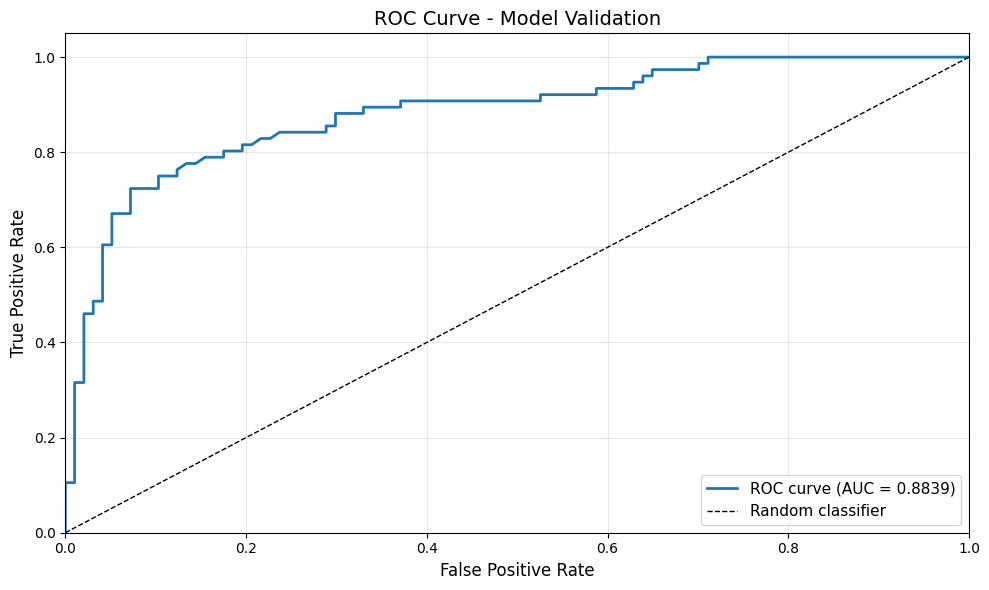

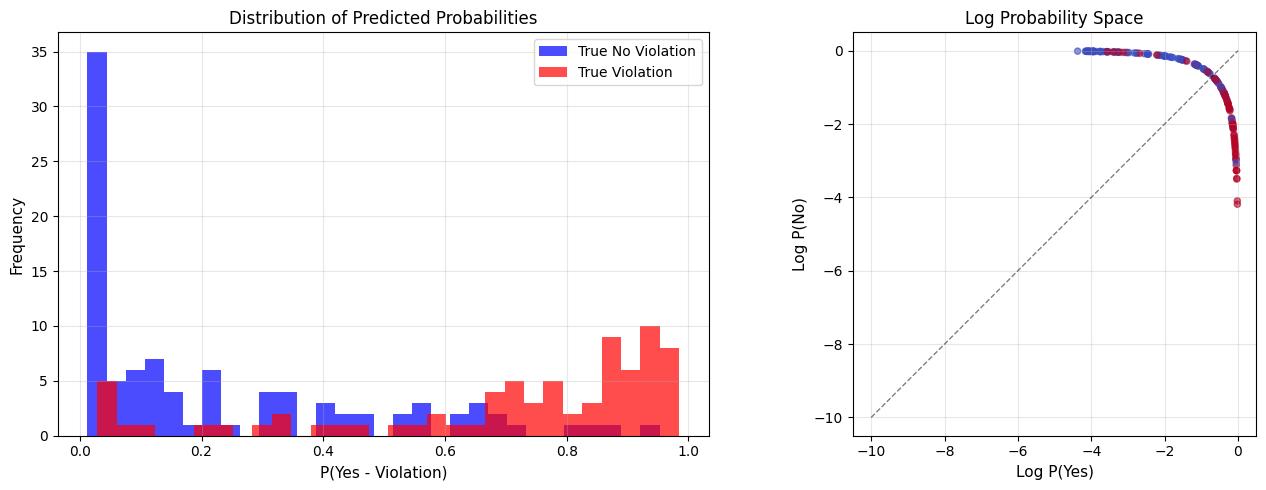

In [14]:
# Optional: Plot ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(true_labels, prob_yes)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f"ROC curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], "k--", linewidth=1, label="Random classifier")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve - Model Validation", fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot distribution of probabilities
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(
    prob_yes[true_labels == 0],
    bins=30,
    alpha=0.7,
    label="True No Violation",
    color="blue",
)
axes[0].hist(
    prob_yes[true_labels == 1], bins=30, alpha=0.7, label="True Violation", color="red"
)
axes[0].set_xlabel("P(Yes - Violation)", fontsize=11)
axes[0].set_ylabel("Frequency", fontsize=11)
axes[0].set_title("Distribution of Predicted Probabilities", fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].scatter(
    yes_logprobs, no_logprobs, c=true_labels, cmap="coolwarm", alpha=0.6, s=20
)
axes[1].plot([-10, 0], [-10, 0], "k--", linewidth=1, alpha=0.5)
axes[1].set_xlabel("Log P(Yes)", fontsize=11)
axes[1].set_ylabel("Log P(No)", fontsize=11)
axes[1].set_title("Log Probability Space", fontsize=12)
axes[1].grid(alpha=0.3)
axes[1].set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.show()

In [15]:
# Extract rule and subreddit information from prompts
import re

rules = []
subreddits = []

for example in eval_dataset:
    prompt_text = example["prompt"][0]["content"]
    
    # Extract rule using regex
    rule_match = re.search(r"<rule>(.*?)</rule>", prompt_text, re.DOTALL)
    subreddit_match = re.search(r"r/(\w+)", prompt_text)
    
    if rule_match:
        rule = rule_match.group(1).strip()
        rules.append(rule)
    else:
        rules.append("Unknown")
    
    if subreddit_match:
        subreddit = subreddit_match.group(1)
        subreddits.append(subreddit)
    else:
        subreddits.append("Unknown")

rules = np.array(rules)
subreddits = np.array(subreddits)

unique_rules = np.unique(rules)
print(f"\nFound {len(unique_rules)} unique rules:")
for i, rule in enumerate(unique_rules):
    count = np.sum(rules == rule)
    print(f"{i+1}. {rule[:80]}... ({count} examples)")



Found 1 unique rules:
1. No Advertising: Spam, referral links, unsolicited advertising, and promotional c... (173 examples)


In [16]:
# Calculate per-rule metrics
print("\n" + "=" * 80)
print("PER-RULE METRICS")
print("=" * 80)

per_rule_metrics = {}

for rule in unique_rules:
    rule_mask = rules == rule
    rule_true = true_labels[rule_mask]
    rule_pred = predictions[rule_mask]
    rule_prob_yes = prob_yes[rule_mask]
    
    # Skip if not enough samples for both classes
    if len(np.unique(rule_true)) < 2:
        print(f"\nRule: {rule[:60]}...")
        print(f"  Samples: {len(rule_true)}")
        print(f"  Skipping - not enough class diversity for AUC")
        continue
    
    rule_acc = accuracy_score(rule_true, rule_pred)
    rule_auc = roc_auc_score(rule_true, rule_prob_yes)
    rule_cm = confusion_matrix(rule_true, rule_pred)
    
    per_rule_metrics[rule] = {
        'accuracy': rule_acc,
        'auc': rule_auc,
        'confusion_matrix': rule_cm,
        'n_samples': len(rule_true),
        'true_labels': rule_true,
        'predictions': rule_pred,
        'prob_yes': rule_prob_yes
    }
    
    print(f"\nRule: {rule[:60]}...")
    print(f"  Samples: {len(rule_true)}")
    print(f"  Accuracy: {rule_acc:.4f} ({rule_acc*100:.2f}%)")
    print(f"  AUC: {rule_auc:.4f}")
    print(f"  Confusion Matrix:")
    print(f"    TN={rule_cm[0,0]:3d}  FP={rule_cm[0,1]:3d}")
    print(f"    FN={rule_cm[1,0]:3d}  TP={rule_cm[1,1]:3d}")

print("\n" + "=" * 80)



PER-RULE METRICS

Rule: No Advertising: Spam, referral links, unsolicited advertisin...
  Samples: 173
  Accuracy: 0.8150 (81.50%)
  AUC: 0.8839
  Confusion Matrix:
    TN= 80  FP= 17
    FN= 15  TP= 61



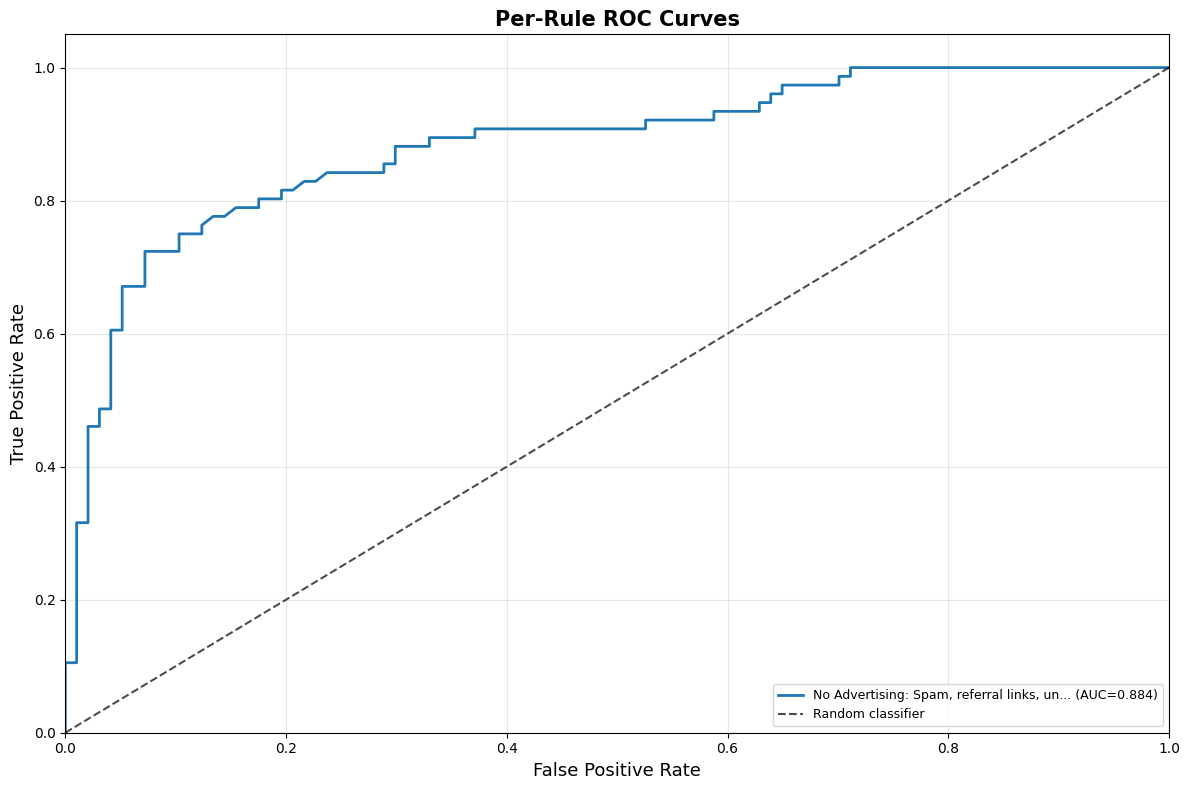

In [17]:
# Plot per-rule ROC curves
n_rules = len(per_rule_metrics)
colors = plt.cm.tab10(np.linspace(0, 1, n_rules))

plt.figure(figsize=(12, 8))

for idx, (rule, metrics) in enumerate(per_rule_metrics.items()):
    fpr_rule, tpr_rule, _ = roc_curve(metrics['true_labels'], metrics['prob_yes'])
    rule_short = rule[:40] + "..." if len(rule) > 40 else rule
    plt.plot(fpr_rule, tpr_rule, linewidth=2, label=f"{rule_short} (AUC={metrics['auc']:.3f})", 
             color=colors[idx])

plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random classifier', alpha=0.7)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('Per-Rule ROC Curves', fontsize=15, fontweight='bold')
plt.legend(loc="lower right", fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


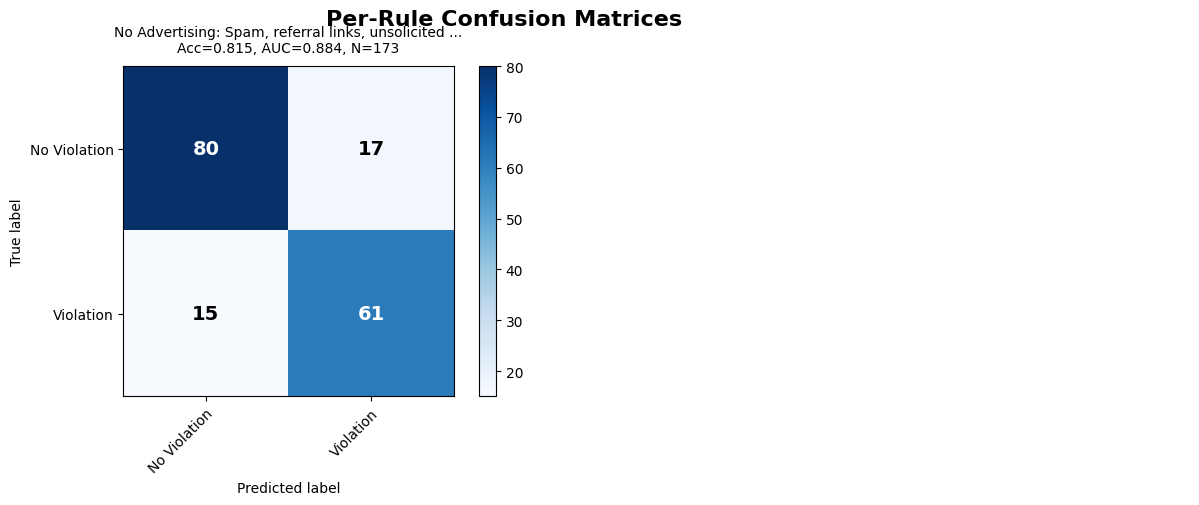

In [18]:
# Plot per-rule confusion matrices
n_rules = len(per_rule_metrics)
n_cols = 2
n_rows = (n_rules + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
if n_rules == 1:
    axes = np.array([axes])
axes = axes.flatten()

for idx, (rule, metrics) in enumerate(per_rule_metrics.items()):
    cm = metrics['confusion_matrix']
    ax = axes[idx]
    
    # Create heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Set ticks and labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=['No Violation', 'Violation'],
           yticklabels=['No Violation', 'Violation'],
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black",
                   fontsize=14, fontweight='bold')
    
    # Set title
    rule_short = rule[:50] + "..." if len(rule) > 50 else rule
    ax.set_title(f"{rule_short}\nAcc={metrics['accuracy']:.3f}, AUC={metrics['auc']:.3f}, N={metrics['n_samples']}", 
                fontsize=10, pad=10)

# Hide empty subplots
for idx in range(len(per_rule_metrics), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('Per-Rule Confusion Matrices', fontsize=16, fontweight='bold', y=1.002)
plt.show()


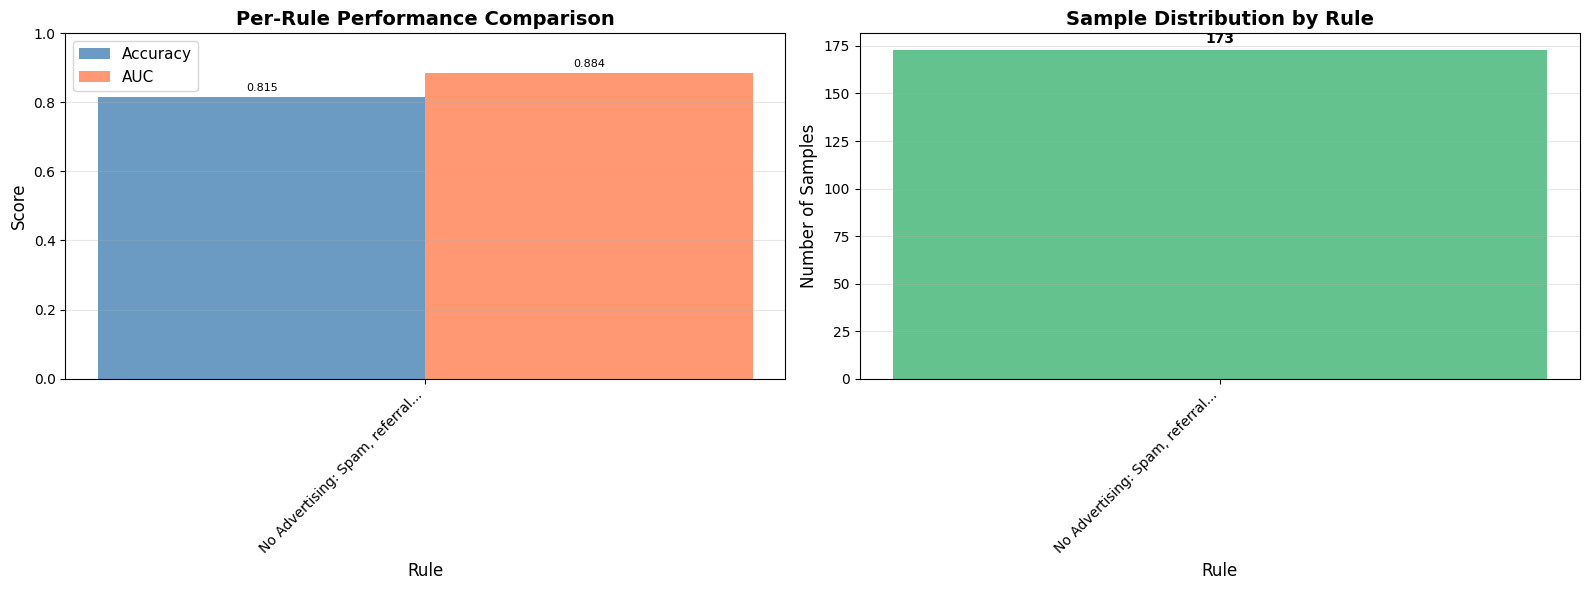

In [19]:
# Bar chart comparing metrics across rules
rule_names = []
accuracies = []
aucs = []
sample_counts = []

for rule, metrics in per_rule_metrics.items():
    rule_short = rule[:30] + "..." if len(rule) > 30 else rule
    rule_names.append(rule_short)
    accuracies.append(metrics['accuracy'])
    aucs.append(metrics['auc'])
    sample_counts.append(metrics['n_samples'])

x = np.arange(len(rule_names))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy and AUC comparison
bars1 = ax1.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8, color='steelblue')
bars2 = ax1.bar(x + width/2, aucs, width, label='AUC', alpha=0.8, color='coral')

ax1.set_xlabel('Rule', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Per-Rule Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(rule_names, rotation=45, ha='right')
ax1.legend(fontsize=11)
ax1.set_ylim([0, 1.0])
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

# Sample count per rule
bars3 = ax2.bar(x, sample_counts, alpha=0.8, color='mediumseagreen')
ax2.set_xlabel('Rule', fontsize=12)
ax2.set_ylabel('Number of Samples', fontsize=12)
ax2.set_title('Sample Distribution by Rule', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(rule_names, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars3:
    height = bar.get_height()
    ax2.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


In [20]:
# Create summary table
import pandas as pd

summary_data = []
for rule, metrics in per_rule_metrics.items():
    cm = metrics['confusion_matrix']
    summary_data.append({
        'Rule': rule[:60] + '...' if len(rule) > 60 else rule,
        'N': metrics['n_samples'],
        'Accuracy': f"{metrics['accuracy']:.4f}",
        'AUC': f"{metrics['auc']:.4f}",
        'TN': cm[0, 0],
        'FP': cm[0, 1],
        'FN': cm[1, 0],
        'TP': cm[1, 1],
        'Precision': f"{cm[1, 1] / (cm[1, 1] + cm[0, 1]):.4f}" if (cm[1, 1] + cm[0, 1]) > 0 else "N/A",
        'Recall': f"{cm[1, 1] / (cm[1, 1] + cm[1, 0]):.4f}" if (cm[1, 1] + cm[1, 0]) > 0 else "N/A",
    })

summary_df = pd.DataFrame(summary_data)

print("\n" + "=" * 120)
print("SUMMARY TABLE - PER-RULE METRICS")
print("=" * 120)
print(summary_df.to_string(index=False))
print("=" * 120)



SUMMARY TABLE - PER-RULE METRICS
                                                           Rule   N Accuracy    AUC  TN  FP  FN  TP Precision Recall
No Advertising: Spam, referral links, unsolicited advertisin... 173   0.8150 0.8839  80  17  15  61    0.7821 0.8026
